In [65]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import chardet


with open("/content/LuncheonHillTasmaniaAprOct2023DWO.csv", 'rb') as f:
    encoding = chardet.detect(f.read())['encoding']

daily_weather = pd.read_csv("/content/LuncheonHillTasmaniaAprOct2023DWO.csv", encoding=encoding)
#print(daily_weather.head())
#print(daily_weather.info())

# Initialize an empty DataFrame to store results of different machine learning algorithms
results = pd.DataFrame(columns=['Precision', 'Recall', 'F1-score', 'Accuracy'])

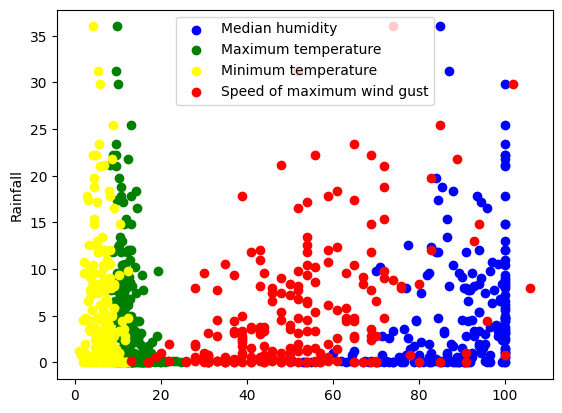

In [66]:
########################
# DATA CLEANUP
########################

#create a new column that will have the average humidity between 9am and 3pm values
daily_weather['Median humidity'] = np.median(daily_weather[['9am relative humidity', '3pm relative humidity']], axis=1)

#fill in missing values
daily_weather['Rainfall'].fillna(0, inplace=True)

# Identify non-numeric values in the '9am wind speed' column and replace with 0
non_numeric_mask = ~pd.to_numeric(daily_weather['9am wind speed'], errors='coerce').notna()
daily_weather.loc[non_numeric_mask, '9am wind speed'] = 0
daily_weather['9am wind speed'] = pd.to_numeric(daily_weather['9am wind speed'])
daily_weather['3pm wind speed'] = pd.to_numeric(daily_weather['3pm wind speed'])

# Fill NaN values in 'Speed of maximum wind gust' with the maximum of '9am wind speed' and '3pm wind speed' for each row
daily_weather['Speed of maximum wind gust'] = daily_weather.apply(lambda row: max(row['9am wind speed'], row['3pm wind speed']) if pd.isna(row['Speed of maximum wind gust']) else row['Speed of maximum wind gust'], axis=1)

# Binarize the Raining (feature) column - Yes (1)/No (0)
threshold = 0
daily_weather['Raining'] = daily_weather['Rainfall'].apply(lambda x: '1' if x > threshold else '0')

#select the columns that can have the potential to affect rain fall
subset_data = daily_weather[['Minimum temperature','Maximum temperature','Median humidity','Speed of maximum wind gust', 'Rainfall', 'Raining']]

#plot Rainfall relationship
plt.scatter(subset_data['Median humidity'], subset_data.Rainfall,  color='blue', label='Median humidity')
plt.scatter(subset_data['Maximum temperature'], subset_data.Rainfall,  color='green', label='Maximum temperature')
plt.scatter(subset_data['Minimum temperature'], subset_data.Rainfall,  color='yellow', label='Minimum temperature')
plt.scatter(subset_data['Speed of maximum wind gust'], subset_data.Rainfall,  color='red', label='Speed of maximum wind gust')
plt.ylabel("Rainfall")
plt.legend()
plt.show()


In [67]:
########################
# Test/Train split
########################

from sklearn.model_selection import train_test_split

array_X = subset_data[['Minimum temperature','Maximum temperature','Median humidity','Speed of maximum wind gust']].values
array_cont_Y = subset_data[['Rainfall']].values

X_train, X_test, Y_train, Y_test = train_test_split(array_X, array_cont_Y, test_size=0.3, random_state=4)

# X_train.shape returns a tuple containing two values: the number of rows (X_train.shape[0])
# and the number of columns (X_train.shape[1]) in the training data
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (149, 4) (149, 1)
Test set: (65, 4) (65, 1)


In [68]:
########################
# Multiple Linear Regression
########################

from sklearn import linear_model
from sklearn import metrics

regression = linear_model.LinearRegression()
regression.fit(X_train, Y_train)

print ('Coefficients: ', regression.coef_) #slope / w
print ('Intercept: ',regression.intercept_) #intercept / b

mlr_predicted_y = regression.predict(X_test)

# Set negative predictions to 0
threshold = 0
mlr_predicted_y[mlr_predicted_y < threshold] = 0

#Mean Absolute Error - average error
print("Mean Absolute error: %.2f" % np.mean(np.absolute(mlr_predicted_y - Y_test)))
print("Mean Squared Error: %.2f" % np.mean((mlr_predicted_y - Y_test) ** 2))

#R-squared represents how close the data points are to the fitted regression line
#The best possible score is 1.0, the lower values are worse. - 0.29
print("Variance score/R2-score: %.2f" % regression.score(X_test , Y_test) )

Coefficients:  [[-0.22765763 -0.36553177  0.08879627  0.12444015]]
Intercept:  [-3.13433651]
Mean Absolute error: 4.80
Mean Squared Error: 48.92
Variance score/R2-score: 0.24


In [69]:
########################
# KNN Regressor
########################
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

#start the algorithm with k=4
k = 7

#Train Model using K
neighbors = KNeighborsRegressor(n_neighbors = k).fit(X_train,Y_train)

#Predicting
ne_predicted_Y = neighbors.predict(X_test)

#Mean Absolute Error - average error
print("Mean Absolute error: %.2f" % np.mean(np.absolute(ne_predicted_Y - Y_test)))
print("Mean Squared Error: %.2f" % np.mean((ne_predicted_Y - Y_test) ** 2))

#R-squared represents how close the data points are to the fitted regression line
#The best possible score is 1.0, the lower values are worse. - 0.29
print("Variance score/R2-score: %.2f" % neighbors.score(X_test , Y_test))


Mean Absolute error: 4.83
Mean Squared Error: 56.31
Variance score/R2-score: 0.14


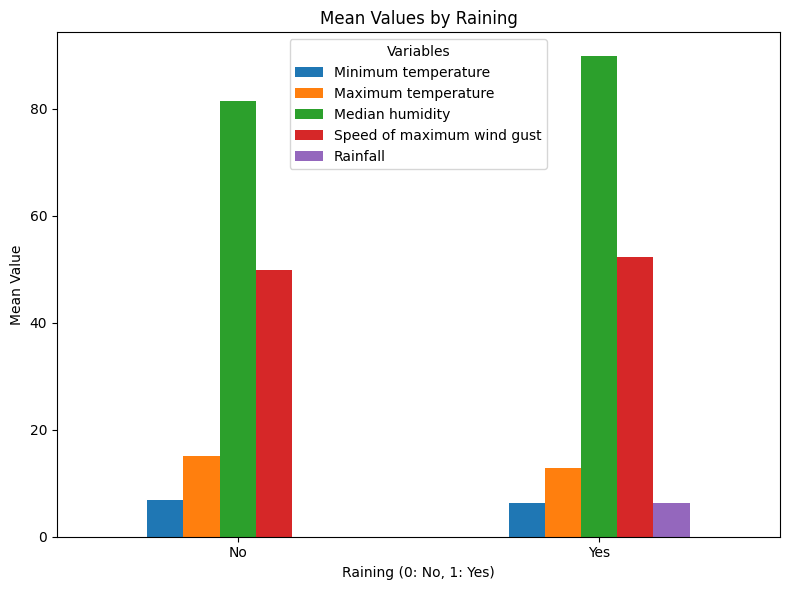

In [70]:

# Group by 'Raining' and calculate average for each group
mean_values = subset_data.groupby('Raining').mean()

mean_values.plot(kind='bar', figsize=(8, 6))
plt.title('Mean Values by Raining')
plt.xlabel('Raining (0: No, 1: Yes)')
plt.ylabel('Mean Value')
plt.legend(title='Variables')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
plt.tight_layout()
plt.show()

In [71]:

#selecting the categorical values for Y
array_categ_Y = subset_data['Raining'].values

#splitting the data again
X_train, X_test, Y_train_cat, Y_test_cat = train_test_split(array_X, array_categ_Y, test_size=0.3, random_state=4)



In [78]:

########################
# KNN Classifier
########################

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import f1_score, jaccard_score

#Training
#calculate the accuracy of KNN for different values of k

# Data Standardization gives the data zero mean and unit variance
scaler = preprocessing.StandardScaler()

# Fit the scaler to your data to compute mean and standard deviation
scaler.fit(array_X)

# Transform the data using the computed mean and standard deviation
standardized_X = scaler.transform(array_X)

#Calculate the accuracy of KNN for different values of k
Ks = 17
mean_acc = []

for n in range(1,Ks):
    #Train Model and Predict
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,Y_train_cat)
    yhat=neigh.predict(X_test)
    mean_acc.append(metrics.accuracy_score(Y_test_cat, yhat))

# Find the k value with the highest accuracy
best_k = mean_acc.index(max(mean_acc)) + 1  # Adding 1 because index starts from 0
best_accuracy = max(mean_acc)

print('Best Accuracy for test set is', best_accuracy, 'achieved with k =', best_k)

#We found the best K, now lets calculate other performance scores
neigh = KNeighborsClassifier(n_neighbors = best_k).fit(X_train,Y_train_cat)
yhat=neigh.predict(X_test)

#higher F1-Score indicates better overall performance of the classifier in terms of both precision and recall. 1 indicates perfect precision and recall
print("F1-Score:", f1_score(Y_test_cat, yhat, average='weighted'))

#Jaccard similarity coefficient, measures the similarity between two sets of data
print("Jaccard Index:", jaccard_score(Y_test_cat, yhat, average='weighted'))

print (classification_report(Y_test_cat, yhat))

report = classification_report(Y_test_cat, yhat, output_dict=True)
metrics = report['weighted avg']
results.loc['KNN'] = [metrics['precision'], metrics['recall'], metrics['f1-score'],report['accuracy']]

Best Accuracy for test set is 0.8307692307692308 achieved with k = 11
F1-Score: 0.7671268902038133
Jaccard Index: 0.690625
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        12
           1       0.83      1.00      0.91        53

    accuracy                           0.83        65
   macro avg       0.91      0.54      0.53        65
weighted avg       0.86      0.83      0.77        65



In [81]:
########################
# Decision Trees Classifier
########################

import sys
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn import metrics
from sklearn.metrics import f1_score, jaccard_score

#create an instance of the DecisionTreeClassifier
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
#X_train, X_test, Y_train_cat, Y_test_cat
#Train
drugTree.fit(X_train,Y_train_cat)

#predictions on the testing dataset
predTree = drugTree.predict(X_test)

#higher F1-Score indicates better overall performance of the classifier in terms of both precision and recall. 1 indicates perfect precision and recall
print("F1-Score:", f1_score(Y_test_cat, predTree, average='weighted'))

#Jaccard similarity coefficient, measures the similarity between two sets of data
print("Jaccard Index:", jaccard_score(Y_test_cat, predTree, average='weighted'))

print (classification_report(Y_test_cat, predTree))

report = classification_report(Y_test_cat, predTree, output_dict=True)
metrics = report['weighted avg']
results.loc['Decision Trees'] = [metrics['precision'], metrics['recall'], metrics['f1-score'],report['accuracy']]

F1-Score: 0.7099390888864573
Jaccard Index: 0.6090544871794872
              precision    recall  f1-score   support

           0       0.14      0.08      0.11        12
           1       0.81      0.89      0.85        53

    accuracy                           0.74        65
   macro avg       0.48      0.49      0.48        65
weighted avg       0.69      0.74      0.71        65



In [82]:
########################
# Logistic Regression
########################
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, jaccard_score, log_loss, classification_report

#{'newton-cholesky', 'liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs'}
LR = LogisticRegression(C=0.5, solver='liblinear').fit(X_train,Y_train_cat)

yhat = LR.predict(X_test)

#the first column is the probability of class 0 and second column is probability of class 1,
yhat_prob = LR.predict_proba(X_test)
#print('Probability', yhat_prob)

print('Jaccard score:', jaccard_score(Y_test_cat, yhat, pos_label='1'))

#Lower values of Log Loss indicate better model performance
print('Log Loss:', log_loss(Y_test_cat, yhat_prob))

print (classification_report(Y_test_cat, yhat))

report = classification_report(Y_test_cat, yhat, output_dict=True)
metrics = report['weighted avg']
results.loc['Logistic Regression'] = [metrics['precision'], metrics['recall'], metrics['f1-score'],report['accuracy']]

Jaccard score: 0.828125
Log Loss: 0.4280576026672325
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        12
           1       0.83      1.00      0.91        53

    accuracy                           0.83        65
   macro avg       0.91      0.54      0.53        65
weighted avg       0.86      0.83      0.77        65



In [83]:
########################
# SVM
########################

from sklearn import svm
from sklearn.metrics import jaccard_score, classification_report

#lets try RBF (Radial Basis Function) as the kerneling funtion
#other kernel funtions: linear, poly, sigmoid, RBF
clf = svm.SVC(kernel='linear').fit(X_train, Y_train_cat)

yhat = clf.predict(X_test)

print('Jaccard score:', jaccard_score(Y_test_cat, yhat, pos_label='1'))
print (classification_report(Y_test_cat, yhat))

report = classification_report(Y_test_cat, yhat, output_dict=True)
metrics = report['weighted avg']
results.loc['SVM'] = [metrics['precision'], metrics['recall'], metrics['f1-score'],report['accuracy']]

Jaccard score: 0.8153846153846154
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.82      1.00      0.90        53

    accuracy                           0.82        65
   macro avg       0.41      0.50      0.45        65
weighted avg       0.66      0.82      0.73        65



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [84]:
# Display results
print("Classification Report Comparison:")
print(results)

Classification Report Comparison:
                     Precision    Recall  F1-score  Accuracy
KNN                   0.859856  0.830769  0.767127  0.830769
Decision Trees        0.687116  0.738462  0.709939  0.738462
Logistic Regression   0.859856  0.830769  0.767127  0.830769
SVM                   0.664852  0.815385  0.732464  0.815385
